In [19]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [20]:
grid_size = 100
grid = np.zeros((grid_size, grid_size))

In [21]:
num_obstacles = int(grid_size * grid_size * 0.2)  # 20% of the grid cells as obstacles
obstacle_positions = random.sample([(i, j) for i in range(grid_size) for j in range(grid_size)], num_obstacles)

# Mark obstacles in the grid
for obs in obstacle_positions:
    grid[obs] = -1  # Obstacle marked as -1

# Randomly place start and goal points
start = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
goal = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))

# Ensure start and goal are not on obstacles
while grid[start] == -1:
    start = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))

while grid[goal] == -1:
    goal = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))

In [22]:
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
gamma = 0.99  # Discount factor
goal_reward = 100
obstacle_penalty = -100
move_penalty = -1

In [23]:
def reward(state):
    if state == goal:
        return goal_reward
    elif grid[state] == -1:
        return obstacle_penalty
    else:
        return move_penalty

def is_valid(state):
    x, y = state
    return 0 <= x < grid_size and 0 <= y < grid_size and grid[state] != -1

def transition(state, action):
    next_state = (state[0] + action[0], state[1] + action[1])
    if is_valid(next_state):
        return next_state
    else:
        return state  # Stay in the same state if invalid move

# Dynamic Programming: Value Iteration (same as before)
def value_iteration():
    values = np.zeros((grid_size, grid_size))
    policy = np.zeros((grid_size, grid_size, len(actions)))  # Policy over actions

    for iteration in range(1000):  # Max iterations for convergence
        delta = 0
        for i in range(grid_size):
            for j in range(grid_size):
                state = (i, j)
                if grid[state] == -1 or state == goal:
                    continue

                max_value = float('-inf')
                for a, action in enumerate(actions):
                    next_state = transition(state, action)
                    r = reward(next_state)
                    value = r + gamma * values[next_state]
                    if value > max_value:
                        max_value = value
                        policy[i, j] = np.eye(len(actions))[a]  # Update policy
                delta = max(delta, abs(max_value - values[state]))
                values[state] = max_value
        if delta < 1e-4:
            break
    return policy, values

In [24]:
class QLearningAgent:
    def __init__(self, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.q_table = np.zeros((grid_size, grid_size, len(actions)))
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(len(actions)))
        else:
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

# Epsilon-Greedy Bandit Agent
class EpsilonGreedyBandit:
    def __init__(self, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.q_table = np.zeros((grid_size, grid_size, len(actions)))
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.action_counts = np.zeros((grid_size, grid_size, len(actions)))

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(len(actions)))
        else:
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error
        self.action_counts[state][action] += 1

In [25]:
def run_agent(agent, num_episodes=1000, ucb=False):
    total_rewards = []
    t = 0
    for episode in range(num_episodes):
        state = start
        total_reward = 0
        while state != goal:
            if ucb:
                action_idx = agent.choose_action(state, t)
            else:
                action_idx = agent.choose_action(state)
            action = actions[action_idx]
            next_state = transition(state, action)
            r = reward(next_state)
            total_reward += r
            agent.update(state, action_idx, r, next_state)
            state = next_state
            t += 1
        total_rewards.append(total_reward)
    return total_rewards

Running Value Iteration...
Value Iteration completed in 62.20 seconds.
Running Q-Learning...
Q-Learning completed in 20.50 seconds.
Running Epsilon-Greedy Bandit...
Epsilon-Greedy Bandit completed in 21.87 seconds.

Benchmark Results:
Value Iteration Time: 62.20 seconds
Q-Learning Time: 20.50 seconds
Epsilon-Greedy Bandit Time: 21.87 seconds


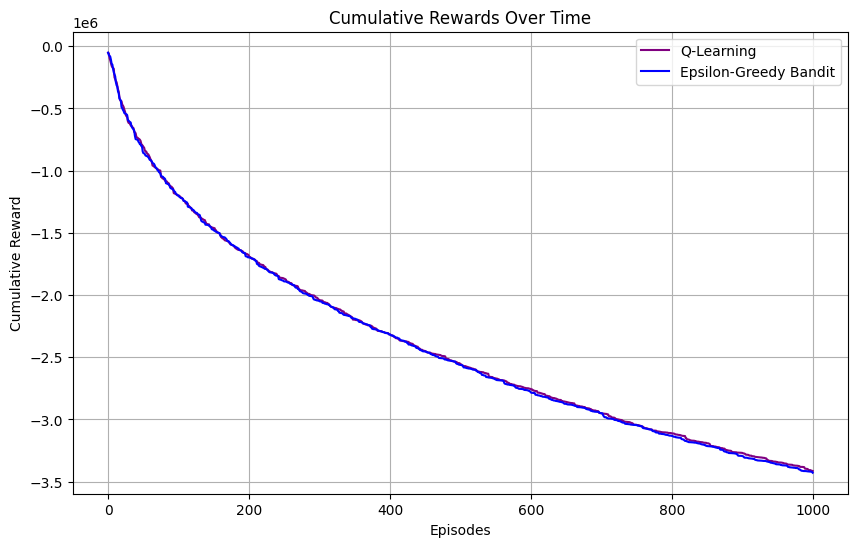

In [26]:
def benchmark():
    print("Running Value Iteration...")
    start_time = time.time()
    policy, _ = value_iteration()
    vi_time = time.time() - start_time
    print(f"Value Iteration completed in {vi_time:.2f} seconds.")

    print("Running Q-Learning...")
    q_learning_agent = QLearningAgent()
    start_time = time.time()
    ql_rewards = run_agent(q_learning_agent)
    ql_time = time.time() - start_time
    print(f"Q-Learning completed in {ql_time:.2f} seconds.")

    print("Running Epsilon-Greedy Bandit...")
    epsilon_greedy_bandit = EpsilonGreedyBandit()
    start_time = time.time()
    eg_rewards = run_agent(epsilon_greedy_bandit)
    eg_time = time.time() - start_time
    print(f"Epsilon-Greedy Bandit completed in {eg_time:.2f} seconds.")



    # Output performance comparison
    print("\nBenchmark Results:")
    print(f"Value Iteration Time: {vi_time:.2f} seconds")
    print(f"Q-Learning Time: {ql_time:.2f} seconds")
    print(f"Epsilon-Greedy Bandit Time: {eg_time:.2f} seconds")


    # Plotting cumulative rewards over episodes
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(ql_rewards), label="Q-Learning", color='purple')
    plt.plot(np.cumsum(eg_rewards), label="Epsilon-Greedy Bandit", color='blue')
    plt.title('Cumulative Rewards Over Time')
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run benchmark
benchmark()